# Steam Predictive Task
## Item-based Collaborative Filtering
### By: Jonathan Tanoto

In [414]:
import gzip
from collections import defaultdict
import scipy
import scipy.optimize
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
import string
import pandas as pd
import seaborn as sns

In [2]:
def parseDataFromFile(fname):
    for l in open(fname):
        yield eval(l)

## Data Pre-processing

In [3]:
data_iu = list(parseDataFromFile("data/steam_items_user.json"))
data_rev = list(parseDataFromFile("data/steam_reviews_user.json"))

In [443]:
data_iu[0]

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 6,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 7,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_forever

In [68]:
userSet = set()
gameSet = set()
playedSet = set()

for d in data_iu[:2000]:
    u = d['steam_id']
    g_lst = []
    for g in d['items']:
        g_lst.append(g['item_id'])
        gameSet.add(g['item_id'])
        playedSet.add((u,g['item_id']))
    userSet.add(u)

In [69]:
data_rev[100]

{'user_id': 'de_Butl3r',
 'user_url': 'http://steamcommunity.com/id/de_Butl3r',
 'reviews': [{'funny': '',
   'posted': 'Posted October 13, 2014.',
   'last_edited': '',
   'item_id': '209870',
   'helpful': '3 of 8 people (38%) found this review helpful',
   'recommend': True,
   'review': 'Its a very fun game i recomend as its nearly like TITANFALL but its FREE!Play this game now'}]}

In [73]:
def get_perc_recommend(g):
    recc = 0
    count = 0
    for datum in data_rev:
        for review in datum['reviews']:
            if review['item_id'] != g: continue
            if review['recommend']:
                recc += 1
            count += 1
    if count == 0: return 0
    return recc/count

Create negative samples

In [285]:
dataset = []
for d in playedSet:
    ret = (d[0], d[1], 1)
    dataset.append(ret)

In [286]:
dataset[:10]

[('76561198027078629', '266840', 1),
 ('76561197975146915', '227300', 1),
 ('76561198045754869', '299460', 1),
 ('76561198028561727', '364360', 1),
 ('76561198100297613', '10150', 1),
 ('76561198072532181', '50130', 1),
 ('76561198025075751', '225320', 1),
 ('76561197992148038', '296630', 1),
 ('76561198023175670', '7000', 1),
 ('76561198039667033', '397080', 1)]

In [81]:
gamesPerUser = defaultdict(set)
usersPerGame = defaultdict(set)

for d in dataset:
    user,gameId = d[0], d[1]
    usersPerGame[gameId].add(user)
    gamesPerUser[user].add(gameId)

In [287]:
neg_data = []
for d in dataset:
    user, gameId = d[0], d[1]
    # sample a random game from a list
    neg_game = random.choice(list(gameSet))
    # repeat process of sampling a game if user has played it
    while neg_game in gamesPerUser[user]:
        neg_game = random.choice(list(gameSet))
    neg_data.append((user, neg_game, 0))

In [288]:
dataset = dataset + neg_data

(u,g,played) pairs (379,130 pairs). Balanced 50/50 of 0/1. Not yet shuffled and split.

### Useful Database for each user

In [101]:
data_iu[0]

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 6,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 7,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_forever

In [317]:
user_data = dict()

for d in data_iu[:2000]:
    datum = []
    # id
    steam_id = d['steam_id']
    # num games
    datum.append(d['items_count'])
    # playtime dict
    pt = dict()
    for g in d['items']:
        pt[g['item_id']] = np.log2(g['playtime_forever']+1)
    datum.append(pt)
    user_data[steam_id] = datum

user_data: 
- dict with key: steam_id
- value: [num_games, dict(game_id: playtime (log2(hrs+1)) )]

In [444]:
user_data

{'76561197970982479': [277,
  {'10': 2.807354922057604,
   '20': 0.0,
   '30': 3.0,
   '40': 0.0,
   '50': 0.0,
   '60': 0.0,
   '70': 0.0,
   '130': 0.0,
   '300': 12.208843990734614,
   '240': 10.85642552862553,
   '3830': 8.383704292474052,
   '2630': 6.247927513443585,
   '3900': 8.405141463136344,
   '34440': 0.0,
   '3920': 1.584962500721156,
   '6400': 8.164906926675688,
   '6910': 11.391243589427443,
   '7670': 9.308339030139408,
   '409710': 0.0,
   '220': 9.445014845868423,
   '320': 0.0,
   '340': 5.247927513443585,
   '360': 0.0,
   '380': 7.400879436282184,
   '400': 7.442943495848728,
   '420': 8.339850002884624,
   '9340': 9.436711542137214,
   '228200': 0.0,
   '11450': 0.0,
   '7940': 10.211888294546004,
   '4700': 8.900866807980748,
   '12900': 6.857980995127572,
   '13250': 0.0,
   '16100': 0.0,
   '15700': 4.857980995127572,
   '15710': 0.0,
   '17330': 5.0,
   '17340': 0.0,
   '22000': 7.614709844115208,
   '500': 9.005624549193879,
   '4560': 10.052568050804153,
 

### Useful Database for each game

In [341]:
dct_hours_array = defaultdict(int)
for d in data_iu[:2000]:
    for i in d['items']:
        g = i['item_id']
        if i['playtime_forever'] == 0: continue
        if dct_hours_array[g] == 0:
            dct_hours_array[g] = [np.log2(i['playtime_forever'] + 1)]
        else:
            dct_hours_array[g].append(np.log2(i['playtime_forever'] + 1))

In [342]:
game_avg_time = defaultdict(int)
for key,value in dct_hours_array.items():
    game_avg_time[key] = np.mean(value)

game_avg_time:
- dict with key: item_id
- value: log2(avg hours played+1) (remove zeroes since it is invalid as users have not played the game)

In [120]:
data_rev[10]

{'user_id': '76561198077246154',
 'user_url': 'http://steamcommunity.com/profiles/76561198077246154',
 'reviews': [{'funny': '',
   'posted': 'Posted June 11.',
   'last_edited': '',
   'item_id': '440',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': 'mt bom'},
  {'funny': '',
   'posted': 'Posted August 25, 2014.',
   'last_edited': 'Last edited July 30, 2015.',
   'item_id': '304930',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': 'É muito bom'}]}

In [135]:
game_rec = defaultdict(int)
for u in data_rev:
    for rev in u['reviews']:
        g = rev['item_id']
        if rev['recommend']: 
            if game_rec[g] == 0:
                game_rec[g] = [1]
            else:
                game_rec[g].append(1)
        else:
            if game_rec[g] == 0:
                game_rec[g] = [0]
            else:
                game_rec[g].append(0)


In [137]:
game_avg_rec = defaultdict(int)
for key,value in game_rec.items():
    game_avg_rec[key] = np.mean(value)

In [139]:
game_avg_rec

defaultdict(int,
            {'1250': 0.9790419161676647,
             '22200': 1.0,
             '43110': 0.9428571428571428,
             '251610': 1.0,
             '227300': 0.981651376146789,
             '239030': 0.9625,
             '248820': 0.9576271186440678,
             '370360': 1.0,
             '237930': 1.0,
             '263360': 1.0,
             '107200': 0.8333333333333334,
             '224500': 0.625,
             '250320': 0.9705882352941176,
             '20920': 0.925,
             '204100': 0.8666666666666667,
             '224600': 0.82,
             '207610': 0.993103448275862,
             '108710': 1.0,
             '211420': 0.8860759493670886,
             '211820': 0.9458689458689459,
             '730': 0.925246076084065,
             '204300': 0.9285714285714286,
             '249130': 0.9285714285714286,
             '550': 0.9720744680851063,
             '65800': 1.0,
             '220': 0.9583333333333334,
             '72850': 0.9428969359331476

game_avg_rec:
- dict with key: item_id
- value: avg of users who recommend the game

In [174]:
game_name_dct = defaultdict(int)
for u in data_iu[:2000]:
    for g in u['items']:
        iid = g['item_id']
        iname = g['item_name']
        if game_name_dct[iid] != 0:
            continue
        game_name_dct[iid] = iname

game_name_dct:
- key: item_id
- value: item_name

In [357]:
game_data = defaultdict(None)
for g in gameSet:
    game_data[g] = [game_name_dct[g], game_avg_time[g], game_avg_rec[g]]

In [358]:
game_data

defaultdict(None,
            {'277630': ['Panzer Tactics HD', 0, 0],
             '214910': ['Air Conflicts: Pacific Carriers',
              6.068118208374362,
              0],
             '29160': ['Blueberry Garden', 2.5437314206251695, 0],
             '241990': ['Sorcerer King', 10.55080449087669, 0],
             '440020': ['bit Dungeon+', 0, 0],
             '218620': ['PAYDAY 2', 10.772634972206209, 0.8003518029903254],
             '107600': ['Waves', 4.419171688217514, 1.0],
             '434010': ['Wishmaster', 7.791376794706638, 0],
             '444160': ['Bonsai', 4.572329121415941, 0],
             '411180': ['Dota 2 Player Profiles', 2.268963058943661, 1.0],
             '340540': ['TDP4:Team Battle', 3.064641508472483, 0.0],
             '2270': ['Wolfenstein 3D', 4.8754151728602375, 1.0],
             '80200': ['Fate of the World', 4.3854934566787716, 0],
             '229600': ["Bientôt l'été", 0, 0],
             '386140': ['After The End: The Harvest', 0, 0],
  

game_data: 
- dict with key: item_id
- value: [game_name, log2(avg hours played+1), percent recommended]

## EDA on games trend

In [359]:
len(game_data)

7865

In [360]:
game_data_arr = []
for key, value in game_data.items():
    game_data_arr.append([key, value[0], value[1], value[2]])
game_data_arr

[['277630', 'Panzer Tactics HD', 0, 0],
 ['214910', 'Air Conflicts: Pacific Carriers', 6.068118208374362, 0],
 ['29160', 'Blueberry Garden', 2.5437314206251695, 0],
 ['241990', 'Sorcerer King', 10.55080449087669, 0],
 ['440020', 'bit Dungeon+', 0, 0],
 ['218620', 'PAYDAY 2', 10.772634972206209, 0.8003518029903254],
 ['107600', 'Waves', 4.419171688217514, 1.0],
 ['434010', 'Wishmaster', 7.791376794706638, 0],
 ['444160', 'Bonsai', 4.572329121415941, 0],
 ['411180', 'Dota 2 Player Profiles', 2.268963058943661, 1.0],
 ['340540', 'TDP4:Team Battle', 3.064641508472483, 0.0],
 ['2270', 'Wolfenstein 3D', 4.8754151728602375, 1.0],
 ['80200', 'Fate of the World', 4.3854934566787716, 0],
 ['229600', "Bientôt l'été", 0, 0],
 ['386140', 'After The End: The Harvest', 0, 0],
 ['307050', 'Shan Gui', 7.785815811792254, 1.0],
 ['382890', 'FINAL FANTASY V', 7.408565981197801, 1.0],
 ['440436',
  "Life Is Strange™ - Directors' Commentary - 7. Social issues",
  3.321928094887362,
  0],
 ['46230', 'Streets

In [347]:
df = pd.DataFrame(data=game_data_arr, columns=['Game ID', 'Game Name', 'Avg. Hours Played (transformed)', '% Recommend'])

In [348]:
df.set_index('Game ID')

Game Name  \
Game ID                                                      
277630                                   Panzer Tactics HD   
214910                     Air Conflicts: Pacific Carriers   
29160                                     Blueberry Garden   
241990                                       Sorcerer King   
440020                                        bit Dungeon+   
...                                                    ...   
314710                                        Mighty No. 9   
246960   Giana Sisters: Twisted Dreams - Rise of the Ow...   
2340                                 Quake II: Ground Zero   
319080           Disney Princess :  My Fairytale Adventure   
259280                        Earth 2150: The Moon Project   

         Avg. Hours Played (transformed)  % Recommend  
Game ID                                                
277630                          0.000000          0.0  
214910                          6.068118          0.0  
29160                           2.543731          0.0  
241990                         10.550804          0.0  
440020                          0.000000          0.0  
...                                  ...          ...  
314710                          8.159871          0.0  
246960                          5.513477          0.0  
2340                            1.146241          0.0  
319080                          0.000000          1.0  
259280                          1.400000          0.0  

[7865 rows x 3 columns]

In [349]:
df.describe()

Avg. Hours Played (transformed)  % Recommend
count                      7865.000000  7865.000000
mean                          5.098602     0.319519
std                           3.152815     0.440584
min                           0.000000     0.000000
25%                           2.696159     0.000000
50%                           6.057040     0.000000
75%                           7.587323     0.888889
max                          15.483658     1.000000

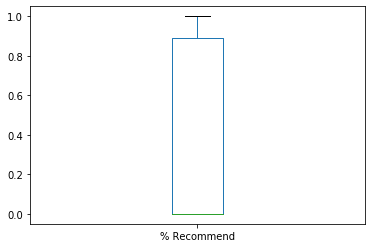

In [350]:
df.plot(kind='box', y='% Recommend')

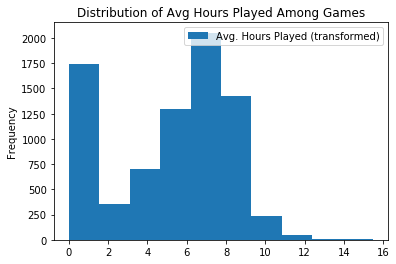

In [351]:
df.plot(kind='hist', y='Avg. Hours Played (transformed)', title='Distribution of Avg Hours Played Among Games')

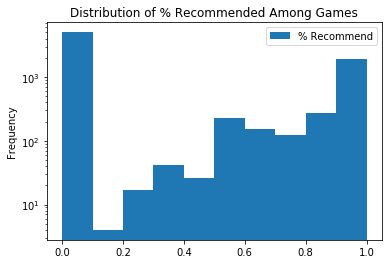

In [352]:
df.plot(kind='hist', y='% Recommend', logy=True, title='Distribution of % Recommended Among Games')

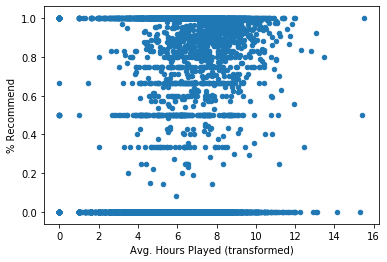

In [353]:
df.plot(kind='scatter', x='Avg. Hours Played (transformed)', y='% Recommend')

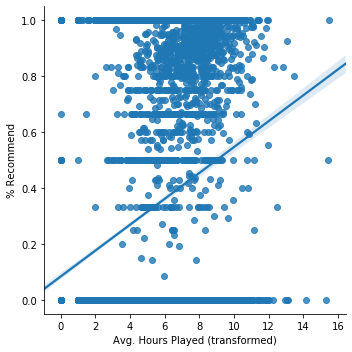

In [354]:
sns.lmplot(x='Avg. Hours Played (transformed)',y='% Recommend',data=df,fit_reg=True) 

Positive Correlation

## EDA on users trend

In [318]:
len(user_data)

1998

In [319]:
user_data

{'76561197970982479': [277,
  {'10': 2.807354922057604,
   '20': 0.0,
   '30': 3.0,
   '40': 0.0,
   '50': 0.0,
   '60': 0.0,
   '70': 0.0,
   '130': 0.0,
   '300': 12.208843990734614,
   '240': 10.85642552862553,
   '3830': 8.383704292474052,
   '2630': 6.247927513443585,
   '3900': 8.405141463136344,
   '34440': 0.0,
   '3920': 1.584962500721156,
   '6400': 8.164906926675688,
   '6910': 11.391243589427443,
   '7670': 9.308339030139408,
   '409710': 0.0,
   '220': 9.445014845868423,
   '320': 0.0,
   '340': 5.247927513443585,
   '360': 0.0,
   '380': 7.400879436282184,
   '400': 7.442943495848728,
   '420': 8.339850002884624,
   '9340': 9.436711542137214,
   '228200': 0.0,
   '11450': 0.0,
   '7940': 10.211888294546004,
   '4700': 8.900866807980748,
   '12900': 6.857980995127572,
   '13250': 0.0,
   '16100': 0.0,
   '15700': 4.857980995127572,
   '15710': 0.0,
   '17330': 5.0,
   '17340': 0.0,
   '22000': 7.614709844115208,
   '500': 9.005624549193879,
   '4560': 10.052568050804153,
 

In [320]:
user_data_arr = []
for u, value in user_data.items():
    if len(list(value[1].values())) > 0:
        mean_hours_per_game = np.mean(list(value[1].values()))
    else: mean_hours_per_game = 0 
    user_data_arr.append([u, value[0], mean_hours_per_game])

In [323]:
df2 = pd.DataFrame(data=user_data_arr, columns=['User ID', 'Number of Games', 'Avg. Hours Played Per Game (transformed)'])

In [324]:
df2.set_index('User ID')

Number of Games  Avg. Hours Played Per Game (transformed)
User ID                                                                     
76561197970982479              277                                  5.712721
76561198035864385              888                                  4.264087
76561198007712555              137                                  5.978855
76561197963445855              328                                  2.672679
76561198002099482              541                                  5.168123
...                            ...                                       ...
76561198084000432               97                                  4.720498
76561198071445832               30                                  8.451713
76561198030912222                0                                  0.000000
76561198055359148              104                                  5.148762
76561198069456949               40                                  4.057500

[1998 rows x 2 columns]

In [325]:
df2.describe()

Number of Games  Avg. Hours Played Per Game (transformed)
count      1998.000000                               1998.000000
mean         94.876877                                  5.105352
std         186.212990                                  2.467711
min           0.000000                                  0.000000
25%          24.000000                                  4.171957
50%          59.000000                                  5.618579
75%         116.000000                                  6.760770
max        6410.000000                                 12.346512

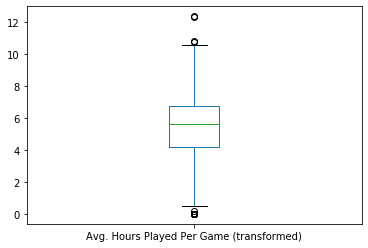

In [327]:
df2.plot(kind='box', y='Avg. Hours Played Per Game (transformed)')

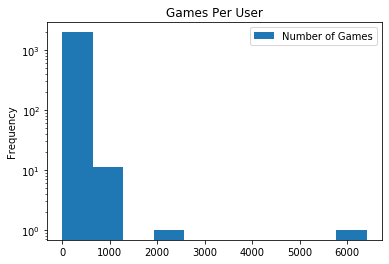

In [328]:
df2.plot(kind='hist', y='Number of Games', logy=True, title='Games Per User')

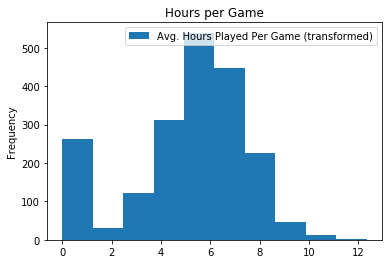

In [329]:
df2.plot(kind='hist', y='Avg. Hours Played Per Game (transformed)', title='Hours per Game')

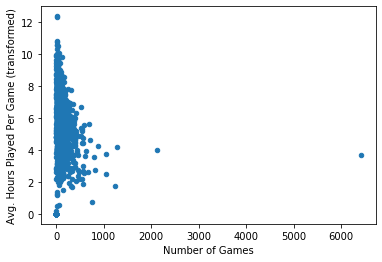

In [330]:
df2.plot(kind='scatter', x='Number of Games', y='Avg. Hours Played Per Game (transformed)')

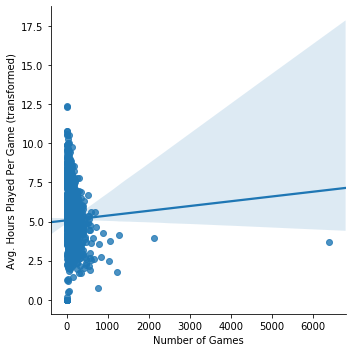

In [331]:
sns.lmplot(x='Number of Games', y='Avg. Hours Played Per Game (transformed)', data=df2, fit_reg=True) 

Inconclusive

## Predictive Task

Task: Predicting if a given user-item pair have played the game before or not

### Splits

In [291]:
data = dataset.copy()
random.Random(4).shuffle(data)

In [296]:
len(data)

379128

In [297]:
data[0]

('76561197994493402', '208580', 1)

In [305]:
X = [d[:2]for d in data]
y = [d[-1]for d in data]

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4) # 0.25 x 0.8 = 0.2
# TVT split: (0.6, 0.2, 0.2)

### Recc System Functions

In [308]:
# standard jaccard
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0: return 0
    return numer / denom

In [311]:
gamesPerUser_train = defaultdict(set)
usersPerGame_train = defaultdict(set)
for d in list(zip(X_train, y_train)):
    if d[1] == 0: continue
    user,gameId = d[0][0], d[0][1]
    usersPerGame_train[gameId].add(user)
    gamesPerUser_train[user].add(gameId)

In [313]:
def get_max_sim(u,g):
    # list of games also played by u
    lst_gprime = list(gamesPerUser_train[u])
    # list of users who also played g
    users_g = usersPerGame_train[g]
    jacs = []
    # iterate through games also played by u
    if len(lst_gprime) < 2: return 0
    for gprime in lst_gprime:
        # no self-comparison
        if gprime == g: continue
        users_gprime = usersPerGame_train[gprime]
        # run Jaccard on users who play g and users who play g'
        jacs.append(Jaccard(users_g, users_gprime))
    return max(jacs)

### A little bit of Rec Sys fun

In [333]:
def mostSimilar(i):
    similarities = []
    users = usersPerGame[i]
    for i2 in usersPerGame:
        if i2 == i: continue
        sim = Jaccard(users, usersPerGame[i2])
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:10]

In [334]:
game_name_dct

defaultdict(int,
            {'10': 'Counter-Strike',
             '20': 'Team Fortress Classic',
             '30': 'Day of Defeat',
             '40': 'Deathmatch Classic',
             '50': 'Half-Life: Opposing Force',
             '60': 'Ricochet',
             '70': 'Half-Life',
             '130': 'Half-Life: Blue Shift',
             '300': 'Day of Defeat: Source',
             '240': 'Counter-Strike: Source',
             '3830': 'Psychonauts',
             '2630': 'Call of Duty 2',
             '3900': "Sid Meier's Civilization IV",
             '34440': "Sid Meier's Civilization IV",
             '3920': "Sid Meier's Pirates!",
             '6400': 'Joint Task Force',
             '6910': 'Deus Ex: Game of the Year Edition',
             '7670': 'BioShock',
             '409710': 'BioShock Remastered',
             '220': 'Half-Life 2',
             '320': 'Half-Life 2: Deathmatch',
             '340': 'Half-Life 2: Lost Coast',
             '360': 'Half-Life Deathmatch: Sou

In [361]:
for d in mostSimilar('7670'):
    print("Similarity: " + str(d[0])) 
    print("    Game: " + str(game_name_dct[d[1]]))

Similarity: 1.0
    Game: BioShock Remastered
Similarity: 0.7493188010899182
    Game: BioShock 2
Similarity: 0.7493188010899182
    Game: BioShock 2 Remastered
Similarity: 0.596529284164859
    Game: BioShock Infinite
Similarity: 0.328
    Game: Fallout: New Vegas
Similarity: 0.3246492985971944
    Game: Tomb Raider
Similarity: 0.3169164882226981
    Game: Dishonored
Similarity: 0.2998790810157195
    Game: Borderlands 2
Similarity: 0.2976190476190476
    Game: The Witcher 2: Assassins of Kings Enhanced Edition
Similarity: 0.2946107784431138
    Game: The Elder Scrolls V: Skyrim


## Feature Engineering

In [367]:
user_avg_hours = dict()
for user, value in user_data.items():
    times = []
    
    # if empty
    if not bool(value[1]): continue
    for item, time in value[1].items():
        times.append(time)
    avg = np.mean(times)
    user_avg_hours[user] = avg


In [369]:
def feature(d):
    u = d[0]
    g = d[1]
    sim = get_max_sim(u, g)
    perc_rec = game_data[g][2]
    game_hours = game_data[g][1]
    game_count = user_data[u][0]
    user_hours = user_avg_hours[u]
    
    return [sim, perc_rec, game_hours, game_count, user_hours]

## Modeling

In [371]:
Xtrain = [feature(d) for d in X_train]
ytrain = y_train

In [372]:
Xtest = [feature(d) for d in X_test]
ytest = y_test

Xvalidation = [feature(d) for d in X_val]
yvalidation = y_val

In [374]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xvalidation_scaled = scaler.transform(Xvalidation)
Xtest_scaled = scaler.transform(Xtest)

In [385]:
X_merged_tv = list(Xtrain_scaled) + list(Xvalidation_scaled)
y_merged_tv = list(ytrain) + list(yvalidation)

In [387]:
train_len = len(Xtrain_scaled)
val_len = len(Xvalidation_scaled)

In [390]:
split_index = [-1 for _ in range(train_len)] + [0 for _ in range(val_len)]
pds = PredefinedSplit(test_fold = split_index)

### Trivial Solution, Guessing

In [401]:
preds = []
for d in Xtest:
    p = np.random.choice([0,1])
    preds.append(p)

In [403]:
correct = np.array(preds) == np.array(ytest)
accuracy = sum(correct) / len(correct)

print("Random Guessing accuracy on test set: ", accuracy)

Random Guessing accuracy on test set:  0.4998944952918524


### LogReg

In [398]:
logreg = linear_model.LogisticRegression(max_iter = 10000)
param_grid= {'C': np.logspace(0,1.5,15)}

clf = GridSearchCV(estimator = logreg,
                   cv=pds,
                   param_grid=param_grid)

# Fit with all data
clf.fit(X_merged_tv, y_merged_tv)

print("Best Parameters: ", clf.best_params_)
print("Accuracy: ", clf.best_score_)

Best Parameters:  {'C': 1.0}
Accuracy:  0.7465908791179806


In [400]:
logreg = linear_model.LogisticRegression(C=1.0, max_iter = 10000)
logreg.fit(X_merged_tv, y_merged_tv)

preds = logreg.predict(Xtest_scaled)

correct = np.array(preds) == np.array(ytest)
accuracy = sum(correct) / len(correct)

print("Logistic Regression accuracy on test set: ", accuracy)

Logistic Regression accuracy on test set:  0.7447972990794715


In [450]:
logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Random Forest Classifier

In [409]:
rfc = RandomForestClassifier()
rfc.fit(X_merged_tv, y_merged_tv)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [410]:
preds = rfc.predict(Xtest_scaled)

correct = np.array(preds) == np.array(ytest)
accuracy = sum(correct) / len(correct)

print("Random Forest Classifier accuracy on test set: ", accuracy)

Random Forest Classifier accuracy on test set:  0.843312320312294


### Support Vector Machine

In [424]:
svc = LinearSVC(C= .00001, max_iter=10000)
svc.fit(X_merged_tv, y_merged_tv)

preds = svc.predict(Xtest_scaled)

correct = np.array(preds) == np.array(ytest)
accuracy = sum(correct) / len(correct)

print("SVM accuracy on test set: ", accuracy)

SVM accuracy on test set:  0.7449423680531744


In [449]:
svc

LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### kNN

In [433]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid= {'n_neighbors': [14,15,16,17,18,19]}

knn_gs = GridSearchCV(estimator = knn,
                   cv=pds,
                   param_grid=param_grid)

# Fit with all data
knn_gs.fit(X_merged_tv, y_merged_tv)

print("Best Parameters: ", knn_gs.best_params_)
print("Accuracy: ", knn_gs.best_score_)

Best Parameters:  {'n_neighbors': 17}
Accuracy:  0.8135731807031888


In [434]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_merged_tv, y_merged_tv)

preds = knn.predict(Xtest_scaled)

correct = np.array(preds) == np.array(ytest)
accuracy = sum(correct) / len(correct)

print("kNN accuracy on test set: ", accuracy)

kNN accuracy on test set:  0.8151425632368845


In [448]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

## Conclusion

In [440]:
results = [['Random Forest Classifier', 0.843312320312294],
           ['K Neighbors Classifier', 0.8151425632368845],
           ['Linear SVC', 0.7449423680531744],
           ['Logistic Regression', 0.7447972990794715],
          ]

In [441]:
df3 = pd.DataFrame(data=results, columns=['Model', 'Accuracy'])

In [442]:
df3

Model  Accuracy
0  Random Forest Classifier  0.843312
1    K Neighbors Classifier  0.815143
2                Linear SVC  0.744942
3       Logistic Regression  0.744797

In [447]:
Xtrain_scaled[0]

array([ 0.93480574,  0.91898475, -0.21676295, -0.32511105,  0.5519315 ])